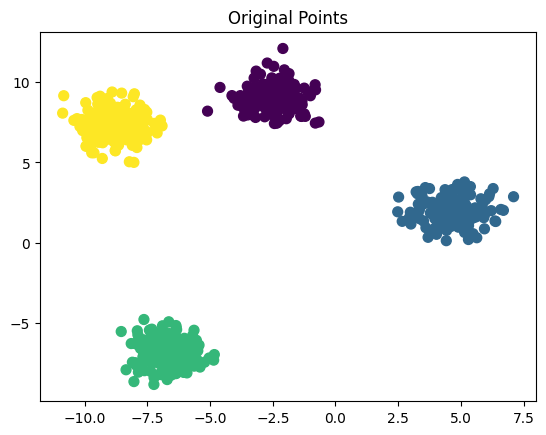

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# إنشاء بيانات اصطناعية
X ,y_true = make_blobs(n_samples=700,centers=4,cluster_std=0.8,random_state=42) 

# رسم البيانات
plt.scatter(X[:, 0], X[:, 1], s=50, c=y_true, cmap='viridis')
plt.title("Original Points")
plt.show()

In [ ]:
# امتداد لخوارزمية Fuzzy C-Means (FCM)
# تُحسِّنها لتتعامل مع مجموعات غير كروية# (إهليلجية)
# تستخدم مصفوفات التغاير (covariance matrices) لكل مجموعة لتحديد شكلها واتجاهها.
# لذلك، تكون أكثر ملاءمة للبيانات المعقدة التي لا تتوزع بشكل دائري.


#########################################################



# numpy (np): لمصفوفات البيانات والعمليات الرياضية.
# det: لحساب المحدد (determinant) لمصفوفة التغاير.
# inv: لإيجاد معكوس (inverse) لمصفوفة التغاير – يستخدم في حساب المسافة.

#------------------------------------------------------------
# data: بيانات الإدخال (مصفوفة ثنائية الأبعاد: (n_samples, n_features)).
# n_clusters: عدد المجموعات المراد إنشاؤها.
# m: معامل الضبابية (fuzziness)، مثل FCM، كلما زادت القيمة زاد التداخل بين المجموعات.
# max_iter: الحد الأقصى للتكرارات.
# error: حد التوقف – إذا كان التغير في العضوية أقل من هذه القيمة، تتوقف الخوارزمية.


#---------------------------------------------------------------
# n_samples: عدد النقاط ( rows).
# n_features: عدد الخصائص (columns).

#------------------------------------------------------------
#
# الخطوة 2: تهيئة مصفوفة العضوية العشوائية
# يتم إنشاء مصفوفة عشوائية U تحتوي على درجات العضوية (من 0 إلى 1).
# ثم نقسم كل صف على مجموعه لضمان أن مجموع درجات العضوية لكل نقطة = 1.

#------------------------------------------------------
# الخطوة 3: حساب مراكز المجموعات
#لكل مجموعة i:
# نرفع درجات العضوية إلى القوة m.
# نحسب مركز المجموعة باستخدام وزن العضوية.
# هذا مشابه لـ FCM، لكن مع الأخذ بالاعتبار الشكل الإهليلجي للمجموعات لاحقًا

#--------------------------------------------------------
#  الخطوة 4: حساب مصفوفات التغاير (Covariance Matrices)
# لكل مجموعة i:
# نحسب الفرق بين كل نقطة والمركز (diff).
# نحسب مصفوفة التغاير باستخدام الوزن um.
# نضيف قيمة صغيرة على القطر الرئيسي (Regularization) لتجنب الانهيار العددي (numerical instability).

#----------------------------------------------------------
# الخطوة 5: إعادة حساب المسافات الضبابية
# هنا نستخدم مسافة ماهالانوبس الضبابية (Mahalanobis Distance) بدلاً من المسافة الإقليدية.
# لأننا نستخدم معكوس مصفوفة التغاير inv(covs[i])، فنأخذ بعين الاعتبار شكل المجموعة وليس فقط موقعها.

#-------------------------------------------------------------
# الخطوة 6: تحديث مصفوفة العضوية

# نحسب درجة العضوية الجديدة بناءً على النسب بين المسافات.
# كلما كانت المسافة أصغر، زادت درجة العضوية.

#---------------------------------------------------------
#  الخطوة 7: شرط التوقف
# نحسب الاختلاف بين مصفوفة العضوية الجديدة والسابقة.
# إذا كان الاختلاف أقل من error، نتوقف.
# وإلا نعيد التكرار.

#-----------------------------------------------------
#  الخطوة الأخيرة: تصنيف النقاط

# نحصل على المجموعة التي تنتمي إليها كل نقطة باستخدام argmax.
# نعيد:
# مراكز المجموعات النهائية centers
# مصفوفة العضوية النهائية U
# تصنيف كل نقطة cluster_membership

In [2]:
import numpy as np
from numpy.linalg import det, inv

def gk_clustering(data, n_clusters, m=2, max_iter=100, error=1e-5):
    n_samples, n_features = data.shape
    U = np.random.rand(n_samples, n_clusters)
    U /= np.sum(U, axis=1, keepdims=True)

    for iteration in range(max_iter):
        # حساب المراكز
        centers = np.zeros((n_clusters, n_features))
        for i in range(n_clusters):
            um = U[:, i] ** m
            centers[i, :] = np.dot(um.T, data) / np.sum(um)

        # حساب مصفوفات التغاير (covariance matrices)
        covs = []
        for i in range(n_clusters):
            diff = data - centers[i]
            um = U[:, i] ** m
            cov = np.dot(um * diff.T, diff) / np.sum(um)
            cov += 1e-6 * np.eye(n_features)  # استقرار عددي
            covs.append(cov)

        # إعادة حساب المسافات الضبابية
        distance_matrix = np.zeros((n_samples, n_clusters))
        for i in range(n_clusters):
            for j in range(n_samples):
                diff = data[j] - centers[i]
                distance_matrix[j, i] = np.sqrt(np.dot(diff.T, inv(covs[i]).dot(diff)))

        # تحديث مصفوفة العضوية
        new_U = np.zeros((n_samples, n_clusters))
        for j in range(n_samples):
            for i in range(n_clusters):
                denom = np.sum([(distance_matrix[j, i] / distance_matrix[j, k]) ** (2 / (m - 1)) for k in range(n_clusters)])
                new_U[j, i] = 1 / denom

        # التوقف إذا لم يكن هناك تغيير كبير
        if np.linalg.norm(new_U - U) < error:
            break

        U = new_U

    cluster_membership = np.argmax(U, axis=1)
    return centers, U, cluster_membership

Silhouette Score: 0.7753
Fuzzy Partition Coefficient (FPC): 225.8219
Silhouette Score: 0.7753


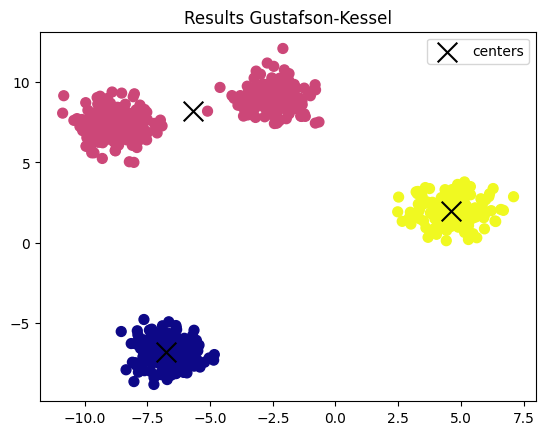

In [10]:
from sklearn.metrics import silhouette_score
centers, U, labels = gk_clustering(X, n_clusters=3, m=2)

silhouette_avg = silhouette_score(X,labels)
print(f'Silhouette Score: {silhouette_avg:.4f}')
def calculate_fpc(U):
    return np.mean(np.sum(U**2, axis=0))

fpc_value = calculate_fpc(U)
print(f'Fuzzy Partition Coefficient (FPC): {fpc_value:.4f}')

silhouette_avg = silhouette_score(X, labels)
print(f'Silhouette Score: {silhouette_avg:.4f}')
# رسم النتائج
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='plasma', s=50)
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, c='black', label='centers')
plt.title("Results Gustafson-Kessel")
plt.legend()
plt.show()

In [ ]:
# FPC : إذا كانت أقل من 0.5، فالمجموعات متداخلة بشكل كبير.
# Silhouette Score : إذا كان أعلى من 0.5، فالنتيجة جيدة عمومًا.
# يمكنك تجربة أعداد مختلفة من المجموعات (n_clusters) لمعرفة أي منها يعطي أفضل تقييم.

### With Customer Segmentation Dataset

In [4]:
import pandas as pd 

df = pd.read_csv("C:\\Users\\Anwar Altorkmani\\Desktop\\Mall_Customers.csv")
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


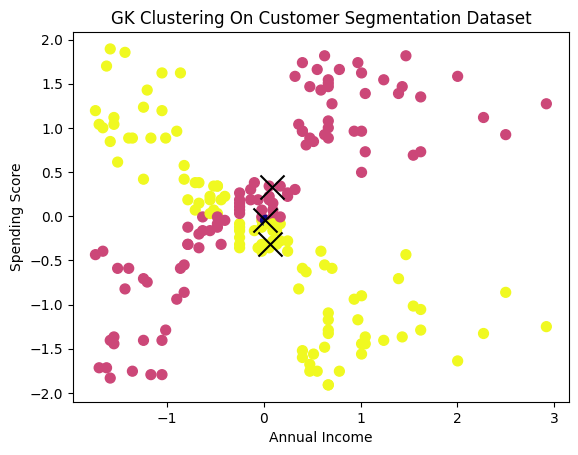

In [ ]:
from sklearn.preprocessing import StandardScaler

# تحضير بيانات العملاء
X_customers = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
X_scaled = StandardScaler().fit_transform(X_customers)

# تشغيل GK
centers, U, cluster_membership = gk_clustering(X_scaled, n_clusters=3)

# رسم النتائج
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_membership, cmap='plasma', s=50)
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=300, c='black')
plt.title("GK Clustering On Customer Segmentation Dataset")
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()

In [ ]:
#التقييم 
# FPC (Fuzzy Partition Coefficient) – يقيس درجة "الوضوح" في تقسيم العضوية.
# Silhouette Score – يقيس مدى جودة التجميع بناءً على المسافات بين النقاط داخل المجموعة وبينها.

# كلما اقتربت قيمة FPC من 1، كانت النتائج أفضل (مجموعات أكثر وضوحًا).



# يُحسب لجميع النقاط باستخدام sklearn.metrics.silhouette_score.
# القيم تتراوح بين -1 و 1:
# قريبة من 1: النقاط متشابهة داخل مجموعتها وأبعد عن المجاورة.
# قريبة من -1: التجميع سيء.
# حوالي 0: المجموعات متداخلة أو غير واضحة.


جاري تشغيل GK على 2 مجموعة...
عدد المجموعات: 2, FPC: 336.5407, Silhouette: 0.4591

جاري تشغيل GK على 3 مجموعة...
عدد المجموعات: 3, FPC: 225.8219, Silhouette: 0.7753

جاري تشغيل GK على 4 مجموعة...
عدد المجموعات: 4, FPC: 164.8698, Silhouette: 0.8317

جاري تشغيل GK على 5 مجموعة...
عدد المجموعات: 5, FPC: 122.9539, Silhouette: 0.7089

جاري تشغيل GK على 6 مجموعة...
عدد المجموعات: 6, FPC: 93.1259, Silhouette: 0.5682


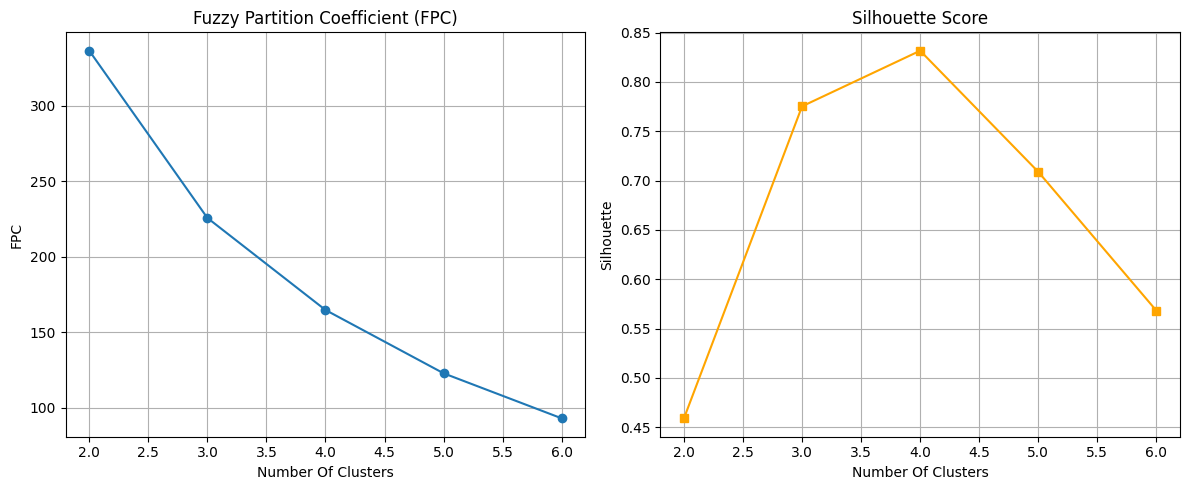

In [ ]:
#For getting the best number for clusters we can use these two methods 
# =============================
# تجربة عدد مختلف من المجموعات
# =============================
cluster_range = range(2, 7)
fpcs = []
silhouettes = []

for n_clusters in cluster_range:
    print(f"\nجاري تشغيل GK على {n_clusters} مجموعة...")
    try:
        centers, U, labels = gk_clustering(X, n_clusters=n_clusters)
        fpc_value = calculate_fpc(U)
        silhouette_avg = silhouette_score(X, labels)

        fpcs.append(fpc_value)
        silhouettes.append(silhouette_avg)

        print(f"عدد المجموعات: {n_clusters}, FPC: {fpc_value:.4f}, Silhouette: {silhouette_avg:.4f}")
    except Exception as e:
        print(f"فشل في تشغيل GK على {n_clusters} مجموعة بسبب الخطأ: {e}")
        fpcs.append(np.nan)
        silhouettes.append(np.nan)


# =============================
# رسم النتائج
# =============================
plt.figure(figsize=(12, 5))

# رسم FPC
plt.subplot(1, 2, 1)
plt.plot(cluster_range, fpcs, 'o-', label='FPC')
plt.title('Fuzzy Partition Coefficient (FPC)')
plt.xlabel('Number Of Clusters')
plt.ylabel('FPC')
plt.grid(True)

# رسم Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouettes, 's-', color='orange', label='Silhouette Score')
plt.title('Silhouette Score')
plt.xlabel('Number Of Clusters')
plt.ylabel('Silhouette')
plt.grid(True)

plt.tight_layout()
plt.show()